In [1]:
import numpy as np
from pybandgap.set_structure import SetStructure, Material, MeshUtils
from pybandgap.fem import global_matrixes
from pybandgap.bandgap import bandgap
from meshes.mix_mesh import truss_part, plate_part

Ne = 4 
a = 0.01
mesh_1, *_ = truss_part(Ne,Ne, a,a)
mesh_2, *_ = plate_part(Ne-2,Ne-2, a/2,a/2) 
meshes = [mesh_1, mesh_2]

In [2]:
aluminum = Material('aluminum', young_modulus=70e9, poisson_ratio=0.33, density=2.7e3)
tungsten = Material('tungsten', young_modulus=411e9, poisson_ratio=0.28, density=19.3e3)

In [3]:
structure = SetStructure(meshes = meshes)
elements_IBZ_1, condition_IBZ_1 = structure.find_irreducible_brillouin_zone(0) # elements mesh 1 in IBZ
elements_IBZ_2, condition_IBZ_2 = structure.find_irreducible_brillouin_zone(1) # elements mesh 2 in IBZ

In [4]:
tungsten_elements = []
max_diameter_elements = [10]

material_elements_1 = np.array([
    tungsten if i in tungsten_elements else aluminum
    for i in elements_IBZ_1])

diameters_elements = np.array([
    0.008 if i in max_diameter_elements else 0.004
    for i in elements_IBZ_1])

In [5]:
centers = MeshUtils.get_midpoints(mesh_2)

condition_1 = centers[:,0]<= a/2/2
condition_2 = centers[:,1]<= a/2/2

condition = np.vstack((condition_IBZ_2, condition_1, condition_2))

tungsten_elements = np.where(np.all(condition, axis=0))[0]

material_elements_2 = np.array([
    tungsten if i in tungsten_elements else aluminum
    for i in elements_IBZ_2])

thicknesses_elements = np.array([0.008*2 for _ in elements_IBZ_2])

In [6]:
structure.set_prop('materials', material_elements_1, 0)
structure.set_prop('diameters', diameters_elements, 0)
structure.set_prop('materials', material_elements_2, 1)
structure.set_prop('thicknesses',thicknesses_elements,1)

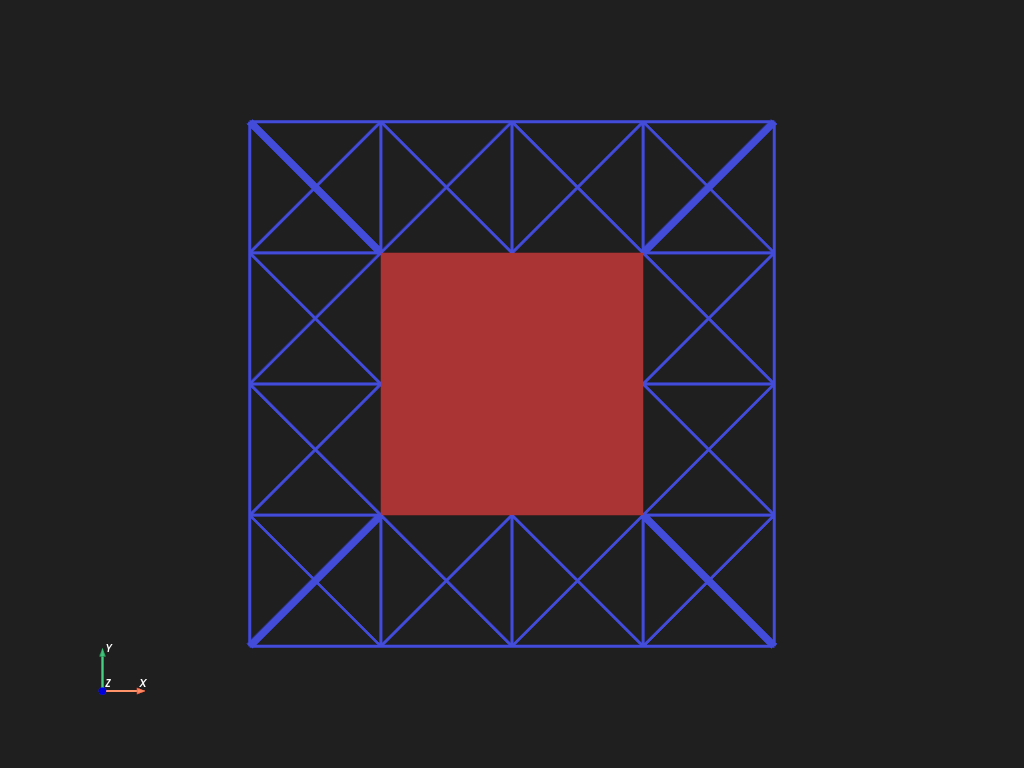

In [7]:
structure.show_structure()

In [ ]:
M_global, K_global = global_matrixes(structure)

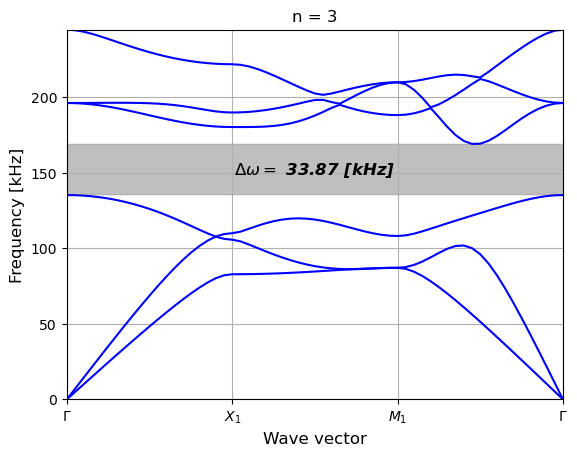

In [9]:
_ = bandgap(3, structure, M_global, K_global, N_eig = 6, plot= True, NINT=60, tol = 1e-15, max_it = 200)